In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy import fftpack
from scipy import stats
from scipy import signal

In [4]:
n_lights = 512
n_pixels = 512

spp = 135

Set objects. Light is at (0, 1)-(1, 1). Sensor is at (0, 0)-(1, 0).

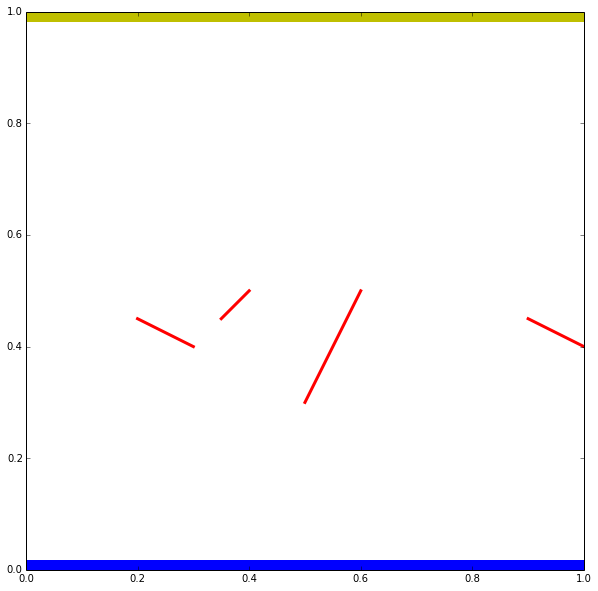

In [5]:
light_sigma = 0.25
d_max = 0.7
pixel_sigma = light_sigma*(1/d_max-1)*0.2

lights = np.exp(-(np.linspace(-0.5, 0.5, 512)/light_sigma)**2/2)
pixels = np.zeros(n_pixels)
objs = \
[
    np.matrix([[0.2, 0.45], [0.3, 0.4]]).T,
    np.matrix([[0.35, 0.45], [0.4, 0.5]]).T,
    np.matrix([[0.5, 0.3], [0.6, 0.5]]).T,
    np.matrix([[0.9, 0.45], [1.0, 0.4]]).T
]

plt.figure(figsize = (10, 10))
plt.plot([0, 1], [0, 0], linewidth = 20, color = 'b')
plt.plot([0, 1], [1, 1], linewidth = 20, color = 'y')
for obj in objs :
    plt.plot(np.squeeze(np.array(obj[0, :])),\
             np.squeeze(np.array(obj[1, :])), linewidth = 3 , color='r')

Compute visibility matrix.

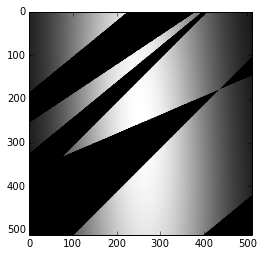

In [6]:
def intersect(a, b, c, d) :
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    d = np.array(d)
    def ccw(a, b, c) :
        cross = (a[0, :]-b[0, :])*(c[1, :]-b[1, :])
        cross -= (a[1, :]-b[1, :])*(c[0, :]-b[0, :])
        return cross > 0
    c1 = np.logical_xor(ccw(a, b, c), ccw(a, b, d))
    c2 = np.logical_xor(ccw(c, d, a), ccw(c, d, b))
    return np.logical_and(c1, c2)

ax = np.repeat((np.arange(n_pixels)+0.5)/n_pixels, n_lights)
ay = np.zeros(n_pixels*n_lights)
bx = np.tile((np.arange(n_lights)+0.5)/n_lights, n_pixels)
by = np.ones(n_pixels*n_lights)
a = np.vstack((ax, ay))
b = np.vstack((bx, by))
vis = np.zeros(n_pixels*n_lights)
for obj in objs :
    c = np.tile(obj[:, 0], (1, n_pixels*n_lights))
    d = np.tile(obj[:, 1], (1, n_pixels*n_lights))
    vis = np.logical_or(vis, intersect(a, b, c, d))
    
vis = np.logical_not(vis).astype(float)
ltm = vis / np.sqrt((ax-bx)**2+1) * np.tile(lights, n_pixels)
vis = vis.reshape((n_pixels, n_lights))
ltm = ltm.reshape((n_pixels, n_lights))
ref = np.sum(ltm, axis = 1)
wnd = np.ones(n_pixels)
wnd[0:int(n_pixels*0.05)] = 0
wnd[int(n_pixels*0.95):n_pixels] = 0
    
plt.figure()
plt.imshow(ltm, cmap = 'gray');

# Row Column Sampling Test

nsamples = 69120
original l2 = 115.724111168
filtered l2 = 60.5753301493


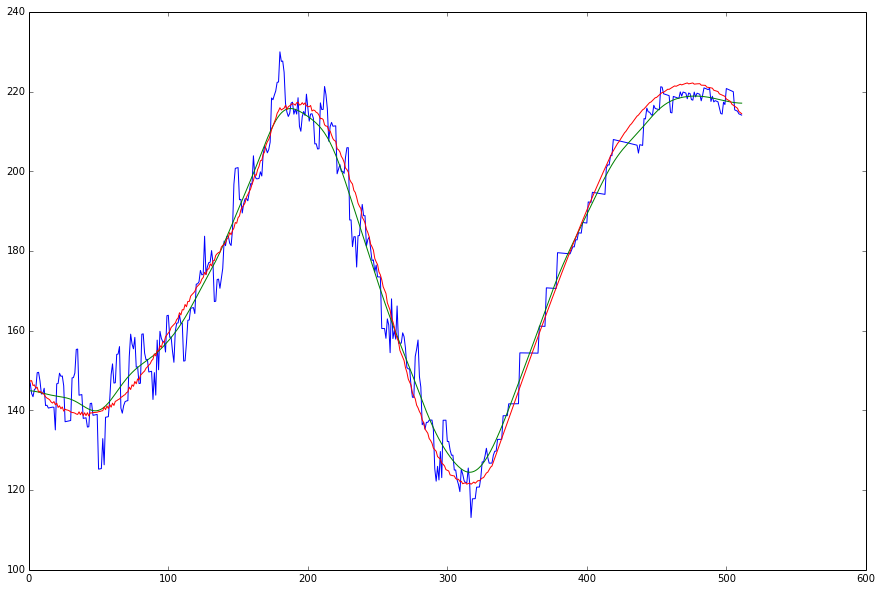

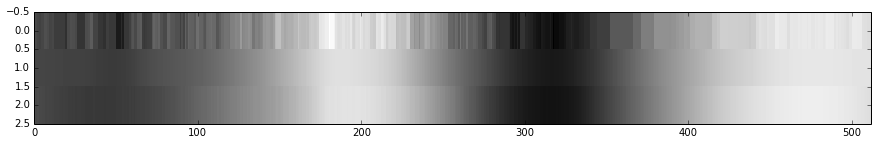

In [8]:
def row_col_sampling(ltm, nr, nc) :
    def dist(a, b) :
        la = np.linalg.norm(a, axis = 0)
        lb = np.linalg.norm(b, axis = 0)
        na = a / la
        nb = b / lb
        m_na = np.repeat(na, len(lb), axis = 1)
        m_nb = np.tile(nb, len(la))
        m_la = np.repeat(la, len(lb), axis = 0)
        m_lb = np.tile(lb, len(la))
        dist_mat = np.sum((m_na-m_nb)**2, axis = 0)*m_la*m_lb
        dist_mat = dist_mat.reshape(len(la), len(lb))
        return dist_mat
    def naive_cluster(rows, nc) :
        center_indices = np.random.permutation(np.arange(0, rows.shape[1]))
        center_indices = center_indices[0:nc]
        centers = rows[:, center_indices]
        dist_mat = dist(centers, rows)
        cluster_indices = np.argmin(dist_mat, axis = 0)
        return center_indices, cluster_indices
    def sampling_cluster(rows, nc) :
        dist_mat = dist(rows, rows)
        probs = np.sum(dist_mat, axis = 0)
        probs /= np.sum(probs)
        rand_gen = stats.rv_discrete(values = (np.arange(len(probs)), probs))
        weights = dict()
        center_indices = np.zeros(nc)
        current_nc = 0
        while current_nc < nc :
            index = rand_gen.rvs()
            if not(index in weights) :
                center_indices[current_nc] = index
                current_nc += 1
                weights[index] = 1 / probs[index]
            else :
                weights[index] += 1 / probs[index]
        centers = rows[:, center_indices.astype(int)]
        for i in range(0, nc) :
            centers[:, i] *= weights[center_indices[i]]
        dist_mat = dist(centers, rows)
        cluster_indices = np.argmin(dist_mat, axis = 0)
        return center_indices, cluster_indices
        
    def cluster(rows, nc) :
        return naive_cluster(rows, nc)
    indices = np.arange(0, ltm.shape[0])
    row_indices = np.zeros(nr)
    patch_size = len(indices) / nr
    for i in range(0, nr) :
        candidates = indices[i*patch_size:np.min(((i+1)*patch_size, len(indices)))]
        row_indices[i] = np.random.choice(candidates)
    row_indices = row_indices.astype(int)
    pixels = np.zeros(ltm.shape[0])
# Sample rows
    rows = ltm[row_indices, :]
    center_indices, cluster_indices = cluster(rows, nc)
    for ci in range(0, nc) :
        cluster_rows = rows[:, np.array(cluster_indices==ci)]
        cluster_ltm = ltm[:, np.array(cluster_indices==ci)]
        energy = np.linalg.norm(cluster_rows, axis = 0)
        total_energy = sum(energy)
        probs = energy / total_energy
        rand_gen = stats.rv_discrete(values = (np.arange(len(probs)), probs))
        index = rand_gen.rvs()
# Sample columns
        col = cluster_ltm[:, index]
        cluster_pixels = col / energy[index] * total_energy
        pixels += cluster_pixels
    return pixels

nr = 48
nc = 96

pixels = row_col_sampling(ltm, nr, nc)
pixels_filtered = ndimage.filters.gaussian_filter(pixels, pixel_sigma*n_pixels)
plt.figure(figsize = (15, 10))
plt.plot(pixels);
plt.plot(pixels_filtered);
plt.plot(ref);

plt.figure(figsize = (15, 2))
plt.imshow(np.vstack((pixels, pixels_filtered, ref)), cmap = 'gray', interpolation='nearest', aspect='auto');

print 'nsamples =', spp * n_pixels
print 'original l2 =', np.sqrt(sum((pixels-ref)**2 * wnd))
print 'filtered l2 =', np.sqrt(sum((pixels_filtered-ref)**2 * wnd))

# Lightcuts Test
* segment tree of [0, n_lights = 512]
* tree node index ~ [1, 1023]
* only consider geometric error terms

nsamples = 63866
original l2 = 41.3746162643
filtered l2 = 28.2942977733


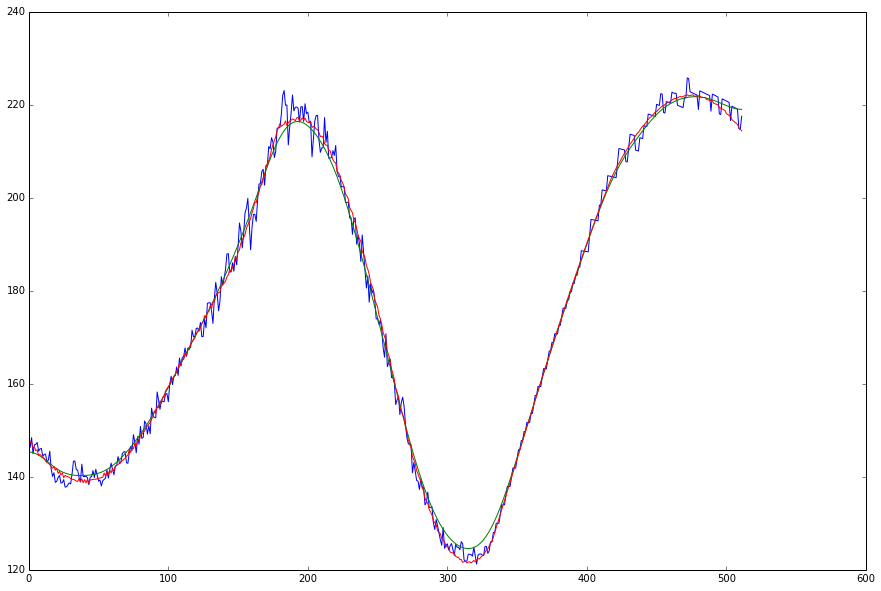

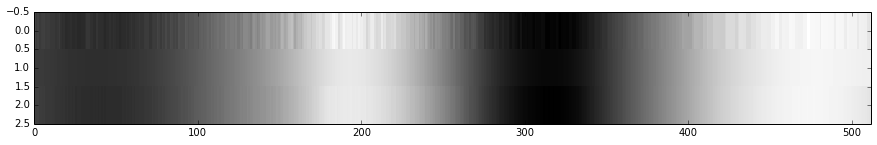

In [9]:
n_tree_nodes = 2 * n_lights
light_reps = np.zeros(n_tree_nodes)
left_bounds = np.zeros(n_tree_nodes)
right_bounds = np.zeros(n_tree_nodes)
cum_lights = np.zeros(n_lights+1)
cum_lights[1:n_lights+1] = np.cumsum(lights)

# return representative light and light interval for each cluster
def build_light_tree(root, l, r):
    left_bounds[root] = l
    right_bounds[root] = r
    if (r - l) * n_lights > 1:
        build_light_tree(root * 2, l, (l + r) * 0.5)
        build_light_tree(root * 2 + 1, (l + r) * 0.5, r)
        light_reps[root] = light_reps[root * 2 + np.random.randint(2)]
    else:
        light_reps[root] = (l + r) * 0.5   

build_light_tree(1, 0, 1)
#print light_reps

def get_cum_intensity(l, r) :
    r_idx = int(r*n_lights+0.5)
    l_idx = int(l*n_lights+0.5)
    return cum_lights[r_idx] - cum_lights[l_idx]

def get_light_index(pos):
    return np.int_(pos * n_lights - 0.5)

def get_pixel_index(pos):
    return np.int_(pos * n_pixels - 0.5)

def get_cluster_intensity(node):
    return get_cum_intensity(left_bounds[node], right_bounds[node])

def calc_cluster_contribution(x, node):
    light_pos = light_reps[node]
    pixel_index = get_pixel_index(x)
    return get_cluster_intensity(node) * \
        vis[pixel_index][get_light_index(light_pos)] / \
        np.sqrt((x - light_pos) ** 2 + 1)

def geo_error_term(x, node):
    if left_bounds[node] <= x and x <= right_bounds[node]:
        return 1
    elif x < left_bounds[node]:
        return 1 / np.sqrt((left_bounds[node] - x) ** 2 + 1)
    else:
        return 1 / np.sqrt((x - right_bounds[node]) ** 2 + 1)

n_samples = 0

def refine_light_cut(pixel_index):
    x = (pixel_index + 0.5) / n_pixels
    ratio = 0.02
    q = list([])
    q.append(1)
    total_radiance = calc_cluster_contribution(x, 1)
    global n_samples
    n_samples += 1
    while True:
        choose_node = -1
        max_err = 0
        for node in q:
            if max_err < geo_error_term(x, node) * get_cluster_intensity(node) and node < n_lights:
                max_err = geo_error_term(x, node) * get_cluster_intensity(node)
                choose_node = node
        if max_err > total_radiance * ratio:
            total_radiance -= calc_cluster_contribution(x, choose_node)
            total_radiance += calc_cluster_contribution(x, choose_node * 2)
            total_radiance += calc_cluster_contribution(x, choose_node * 2 + 1)
            q.remove(choose_node)
            q.append(choose_node * 2)
            q.append(choose_node * 2 + 1)
            n_samples += 1
        else:
            break
    return total_radiance

pixels = np.zeros(n_pixels)
for i in range(n_pixels):
    pixels[i] += refine_light_cut(i)
pixels_filtered = ndimage.filters.gaussian_filter(pixels, pixel_sigma*n_pixels)
plt.figure(figsize = (15, 10))
plt.plot(pixels);
plt.plot(pixels_filtered);
plt.plot(ref);

plt.figure(figsize = (15, 2))
plt.imshow(np.vstack((pixels, pixels_filtered, ref)), cmap = 'gray', interpolation='nearest', aspect='auto');
        
print 'nsamples =', n_samples
print 'original l2 =', np.sqrt(sum((pixels-ref)**2 * wnd))
print 'filtered l2 =', np.sqrt(sum((pixels_filtered-ref)**2 * wnd))

# AA Filtering Test

nsamples = 69120
original l2 = 267.986472219
filtered l2 = 39.3144435163


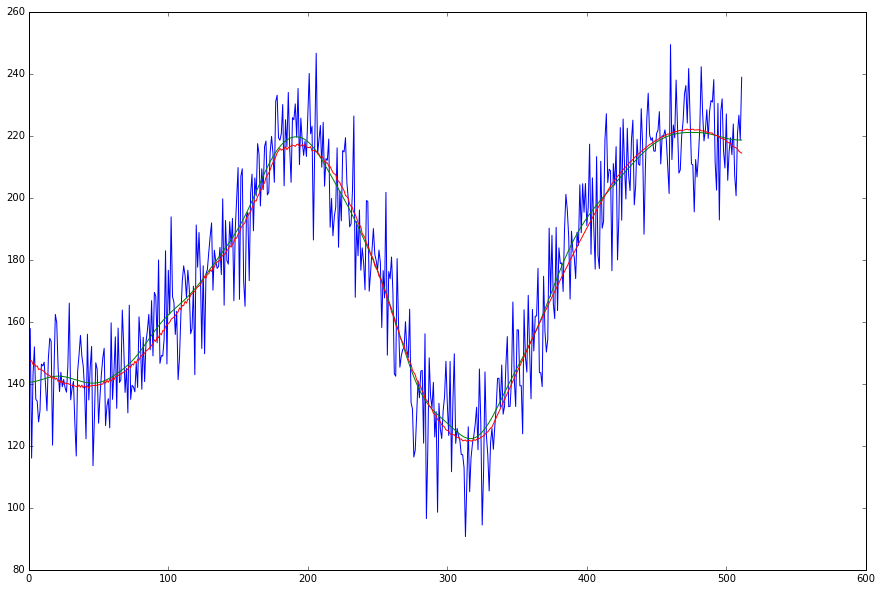

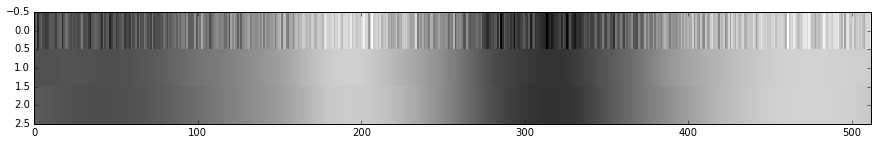

In [7]:
imp = 1 # 0--uniform 1--importance

probs = lights / sum(lights)
rand_gen = stats.rv_discrete(values = (np.arange(len(probs)), probs))

for i in range(n_pixels) :
    p = 1 / n_pixels
    sp_array = np.random.randint(n_lights, size=spp)
    if imp :
        sp_array = rand_gen.rvs(size = spp)
        p = probs[sp_array]
    pixels[i] = sum(ltm[i, sp_array] / p) / spp
    
pixels_filtered = ndimage.filters.gaussian_filter(pixels, pixel_sigma*n_pixels)
plt.figure(figsize = (15, 10))
plt.plot(pixels);
plt.plot(pixels_filtered);
plt.plot(np.sum(ltm, axis = 1));

plt.figure(figsize = (15, 2))
plt.imshow(np.vstack((pixels, pixels_filtered, np.sum(ltm, axis = 1))), cmap = 'gray', interpolation='nearest', aspect='auto');

print 'nsamples =', spp * n_pixels
print 'original l2 =', np.sqrt(sum((pixels-ref)**2 * wnd))
print 'filtered l2 =', np.sqrt(sum((pixels_filtered-ref)**2 * wnd))